# Fingers Recognition in Real Time
## Importing Libraries

In [1]:
import os
import cv2
import glob
import keras
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Input,Dense,Conv2D,MaxPooling2D,BatchNormalization,Flatten,Dropout

## Loading the dataset

In [2]:
TRAIN_PATH = './fingers/train/*'
TEST_PATH = './fingers/test/*'
FILE_NAME = 'realtime_fingers_detection.hdf5'
MODEL_PATH = 'realtime_fingers_model/'
KERNEL = (3,3)
CLASSES = 6
IMAGE_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50

## Util Functions

In [3]:
def load_dataset(path):
    dataset = [(int(img_path[-6]), load_image(img_path)) for img_path in glob.glob(path)]
    return dataset

def load_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE))
    return img

def show_image(img):
    imgplot = plt.imshow(img, cmap='gray')
    plt.show()

def show_images(dataset, grid_size=5):
    _, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = [y for x in axes for y in x]
    for (i, (label, img)) in enumerate(random.sample(dataset, grid_size**2)):
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(label)
        axes[i].axis('off')

def process_stream_image(img):
    img = cv2.copyMakeBorder(img.copy(), 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    img = process_image(img, thresh_low=70, thresh_high=250)
    img[img < 1] = 0
    return img

def process_image(img, thresh_low=80, thresh_high=255):
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = cv2.GaussianBlur(img, (5, 5), 0)
    _, img = cv2.threshold(img, thresh_low, thresh_high, cv2.THRESH_BINARY)
    im_floodfill = img.copy()
    h, w = img.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_floodfill, mask, (0,0), 255)
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)
    img = img | im_floodfill_inv    
    img = img/255
    img = np.reshape(img, (IMAGE_SIZE, IMAGE_SIZE, 1))
    return img

def process_dataset(dataset):
    dataset = [(label, process_image(img)) for (label, img) in dataset]
    return dataset

In [4]:
train_set = load_dataset(TRAIN_PATH)
test_set = load_dataset(TEST_PATH)

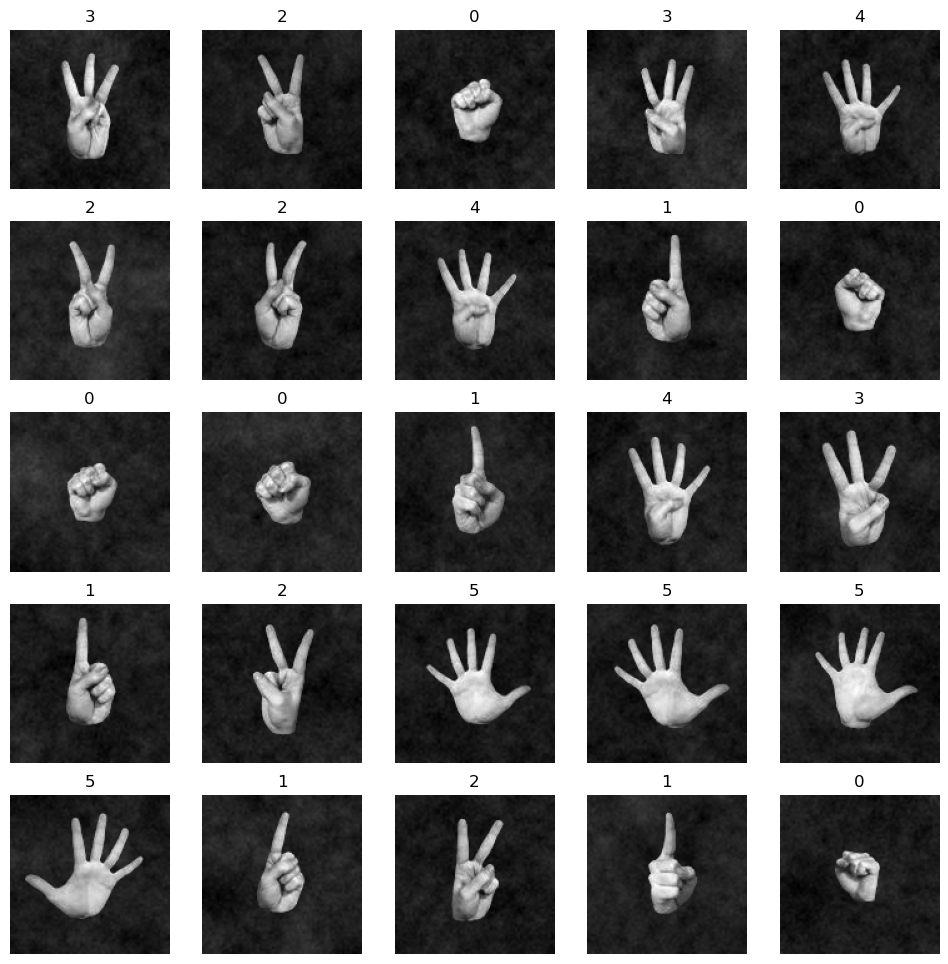

In [5]:
show_images(train_set)

## Modify the data

For real time image processing we are going to convert the video feed from the web cam to a black and white image and then will pass it to the model for inference. So we have to train our model on that data.
We will now convert our color images to grayscale and then to black and white masks.

In [6]:
training_set = process_dataset(train_set)
testing_set = process_dataset(test_set)

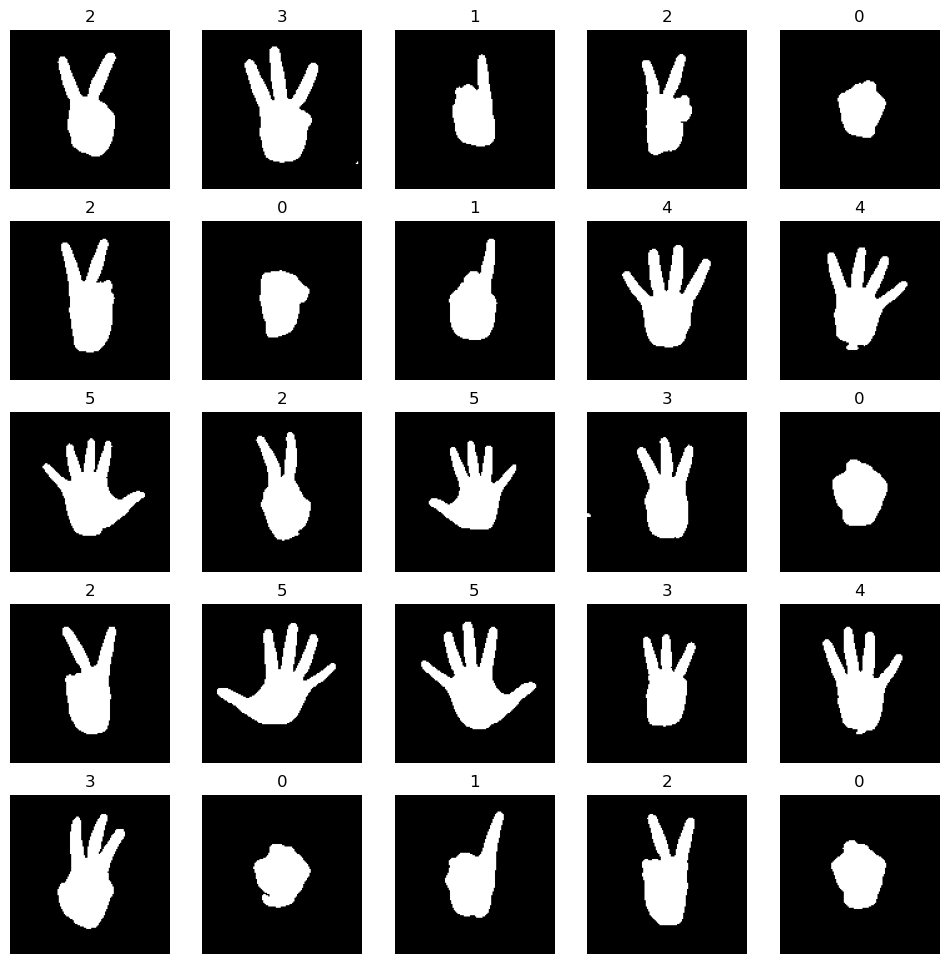

In [7]:
show_images(training_set)

## Splitting the dataset in Images and labels

In [9]:
X_train = np.array([img for (_, img) in training_set])
Y_train = keras.utils.to_categorical([label for (label, _) in training_set], num_classes=CLASSES)
X_test = np.array([img for (_, img) in testing_set])
Y_test = keras.utils.to_categorical([label for (label, _) in testing_set], num_classes=CLASSES)

In [11]:
print(X_train.shape)
print(Y_train.shape)

(18000, 128, 128, 1)
(18000, 6)


## Data Augmentation

Generating modified data using the given dataset. We will scale, rotate and transform these images to generate a variety of images for our dataset.

In [11]:
img_generator = keras.preprocessing.image.ImageDataGenerator(
                    rotation_range=45,
                    zoom_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range = 0.1,
                    horizontal_flip=False,
                    fill_mode="nearest"
                )

## Creating the Model

In [16]:
def get_model():
    input_shape=[IMAGE_SIZE, IMAGE_SIZE, 1]
        
    model = keras.models.Sequential([
            Input(input_shape),
            Conv2D(64, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(128, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(256, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(64, KERNEL, strides=(1, 1), activation='relu'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Dropout(0.2),
            Flatten(),
            Dense(CLASSES, activation="softmax"),
        ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Model Training

In [17]:
checkpoint = ModelCheckpoint(FILE_NAME, monitor='loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', verbose=1, factor=0.5, patience=1, min_lr=0.0001, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss', verbose=1, min_delta=0, restore_best_weights = True, patience=3, mode='min')
callbacks_list = [checkpoint, earlyStopping, reduce_lr]

model = get_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_8 (Bat  (None, 63, 63, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                            
                                                      

In [17]:
# Training the model if the model is not saved
history = model.fit(
        x = img_generator.flow(X_train, Y_train, batch_size=BATCH_SIZE),
        steps_per_epoch= X_train.shape[0] // BATCH_SIZE,
        validation_data= img_generator.flow(X_test, Y_test, batch_size=BATCH_SIZE),
        validation_steps= X_test.shape[0] // BATCH_SIZE,
        epochs= EPOCHS,
        callbacks= callbacks_list
    )

Epoch 1/50
562/562 [==============================] - 536s 948ms/step - loss: 0.5518 - accuracy: 0.7891 - val_loss: 0.7239 - val_accuracy: 0.7065 - lr: 1.0000e-04
Epoch 2/50
562/562 [==============================] - 534s 949ms/step - loss: 0.2259 - accuracy: 0.9288 - val_loss: 0.1312 - val_accuracy: 0.9741 - lr: 1.0000e-04
Epoch 3/50
562/562 [==============================] - 535s 953ms/step - loss: 0.1412 - accuracy: 0.9624 - val_loss: 0.1150 - val_accuracy: 0.9668 - lr: 1.0000e-04
Epoch 4/50
562/562 [==============================] - 546s 971ms/step - loss: 0.0964 - accuracy: 0.9765 - val_loss: 0.0590 - val_accuracy: 0.9894 - lr: 1.0000e-04
Epoch 5/50
562/562 [==============================] - 554s 987ms/step - loss: 0.0699 - accuracy: 0.9833 - val_loss: 0.0505 - val_accuracy: 0.9905 - lr: 1.0000e-04
Epoch 6/50
562/562 [==============================] - 606s 1s/step - loss: 0.0536 - accuracy: 0.9878 - val_loss: 0.0393 - val_accuracy: 0.9936 - lr: 1.0000e-04
Epoch 7/50
562/562 [=====

In [18]:
tf.saved_model.save(model, MODEL_PATH)
print("Model Saved at path:" + MODEL_PATH)

INFO:tensorflow:Assets written to: realtime_fingers_model/assets


INFO:tensorflow:Assets written to: realtime_fingers_model/assets


Model Saved at path:realtime_fingers_model/


In [19]:
model.load_weights(MODEL_PATH)
loss, acc = model.evaluate(X_test, Y_test)

113/113 [==============================] - 28s 244ms/step - loss: 0.0023 - accuracy: 0.9997


## Plotting the metrics

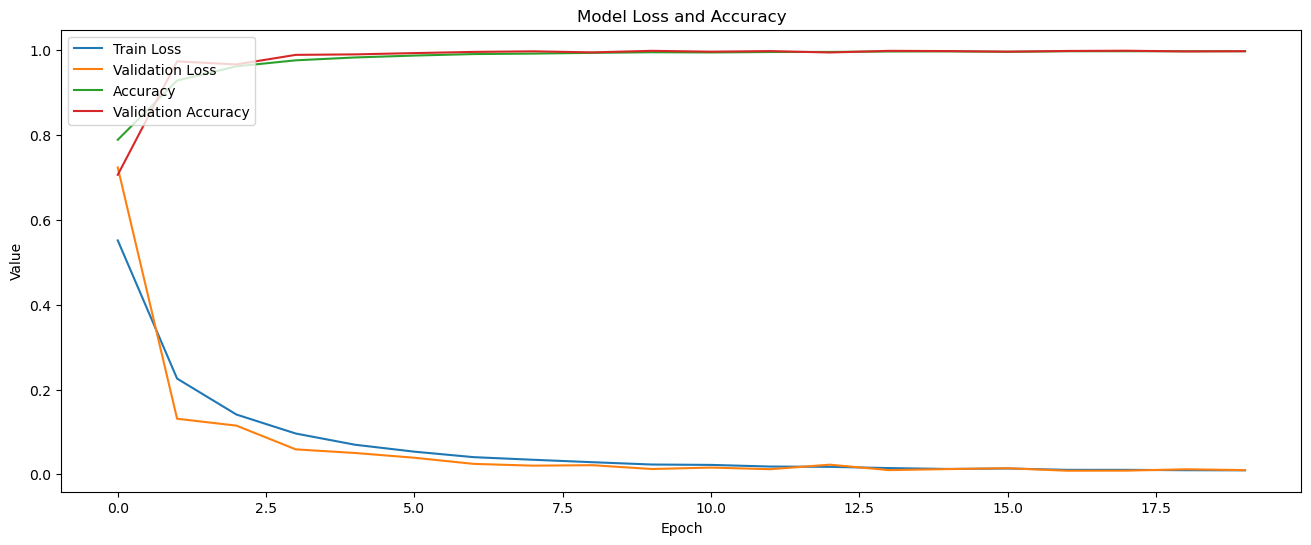

In [22]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss', "Accuracy", "Validation Accuracy"], loc='upper left')
plt.savefig('training.png')
plt.show()

## Loading the model

In [23]:
class FingerClassifier(object):
    def __init__(self, model_object):
        self.detect = model_object

    def get_classification(self, img):
        img = img.reshape(1, *img.shape)
        img = tf.constant(img, dtype=float)
        unique, counts = np.unique(img, return_counts=True)
        if (len(counts) <= 1 or counts[1] < 1200):
            return -1;
        output = self.detect(img)
        return np.argmax(output)

In [24]:
obj = FingerClassifier(model)

In [25]:
camMarginX = 10
camMarginY = 10
scale = 10
LB = np.array([0, 90, 0])
UB = np.array([180, 220, 255])    
roi = (400, 120, 250, 250)
rval = True

cam = cv2.VideoCapture(0)

while rval:
    rval, img = cam.read()
    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    x, y, w, h = roi
    cropped = img[y:y+h, x:x+w]
    
    cv2.imshow('Original', cropped)
    cropped = process_stream_image(cropped)
    # show_image(cropped)
    cv2.imshow('Mask', cropped)
    fingers = obj.get_classification(cropped)
    print(fingers, end=' ')
    if(cv2.waitKey(25) & 0xFF == 27):
        break;

cam.release()
cv2.destroyAllWindows()

-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 0 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 